In [1]:
# Basics
import os
import sys
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import arviz as az  # Visualization
import pytensor  # Graph-based tensor library
import hssm
from ssms.basic_simulators import simulator

import pymc as pm

# import ssms.basic_simulators # Model simulators
import hddm_wfpt
import bambi as bmb

# Setting float precision in pytensor
# pytensor.config.floatX = "float32"

%matplotlib inline
%config InlineBackend.figure_format='retina'

/Users/corrado/opt/anaconda3/envs/hssm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from hssm.distribution_utils import (
    make_distribution,  # A general function for making Distribution classes
    make_distribution_from_onnx,  # Makes Distribution classes from onnx files
    make_distribution_from_blackbox,  # Makes Distribution classes from callables
)

# pm.Distributions that represents the top-level distribution for
# DDM models (the Wiener First-Passage Time distribution)
from hssm.likelihoods import logp_ddm_sdv, DDM

In [24]:
data = pd.read_csv(
    "/Users/corrado/_repositories/memory_surprise/data/prep/memory/memory_surprise_input_for_hddmrl.csv"
)

# Modifying 'response' column
data['response'] = np.where(data['response'] == 1, 1, -1)

data.head()

,subj_idx,response,participant_code,is_self,is_surprise,condition,rt
0,1,1,an_ta_1995_12_26_945_m,SELF,NOSURPRISE,CE,2.709
1,1,1,an_ta_1995_12_26_945_m,SELF,NOSURPRISE,CE,1.958
2,1,-1,an_ta_1995_12_26_945_m,SELF,NOSURPRISE,CE,3.000
3,1,1,an_ta_1995_12_26_945_m,SELF,NOSURPRISE,CE,1.873
4,1,-1,an_ta_1995_12_26_945_m,SELF,NOSURPRISE,CE,1.624


In [4]:
df = pd.get_dummies(data, columns=['condition'])
df.head()

,subj_idx,response,participant_code,is_self,is_surprise,rt,condition_CE,condition_CO,condition_SE,condition_SO
0,1,1.000000,an_ta_1995_12_26_945_m,SELF,NOSURPRISE,2.709,True,False,False,False
1,1,1.000000,an_ta_1995_12_26_945_m,SELF,NOSURPRISE,1.958,True,False,False,False
2,1,0.625841,an_ta_1995_12_26_945_m,SELF,NOSURPRISE,3.000,True,False,False,False
3,1,1.000000,an_ta_1995_12_26_945_m,SELF,NOSURPRISE,1.873,True,False,False,False
4,1,0.000000,an_ta_1995_12_26_945_m,SELF,NOSURPRISE,1.624,True,False,False,False


In [ ]:
df = data.astype('float32')

In [37]:
model_reg = hssm.HSSM(
    data = data,
    include = [
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
            },
            "formula": "v ~ 1 + condition + (1 | subj_idx)",
            "link": "identity",
        }
    ],
)

In [42]:
model_reg = hssm.HSSM(
    data = data,
    include=[
        {
            "name": "t",  # Boundary separation
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                # If you have specific priors for condition effects, add them here
            },
            "formula": "t ~ 1 + (1 | subj_idx)",  # Including condition as a predictor
            "link": "identity",
        },
        {
            "name": "v",  # Drift rate
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                # Add specific priors for condition effects for v here, if needed
            },
            "formula": "v ~ 1 + condition + (1 | subj_idx)",  # Including condition as a predictor
            "link": "identity",
        }
        # Include other parameters as needed
    ],
)

In [43]:
model_reg

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 800

Parameters:

v:
    Formula: v ~ 1 + condition + (1 | subj_idx)
    Priors:
        v_Intercept ~ Uniform(lower: -3.0, upper: 3.0)
        v_condition ~ Normal(mu: [0. 0. 0.], sigma: [5.7735 5.7735 5.7735])
        v_1|subj_idx ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
    Link: identity
    Explicit bounds: (-inf, inf)
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Formula: t ~ 1 + (1 | subj_idx)
    Priors:
        t_Intercept ~ Uniform(lower: -3.0, upper: 3.0)
        t_1|subj_idx ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
    Link: identity
    Explicit bounds: (0.0, inf)

Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)

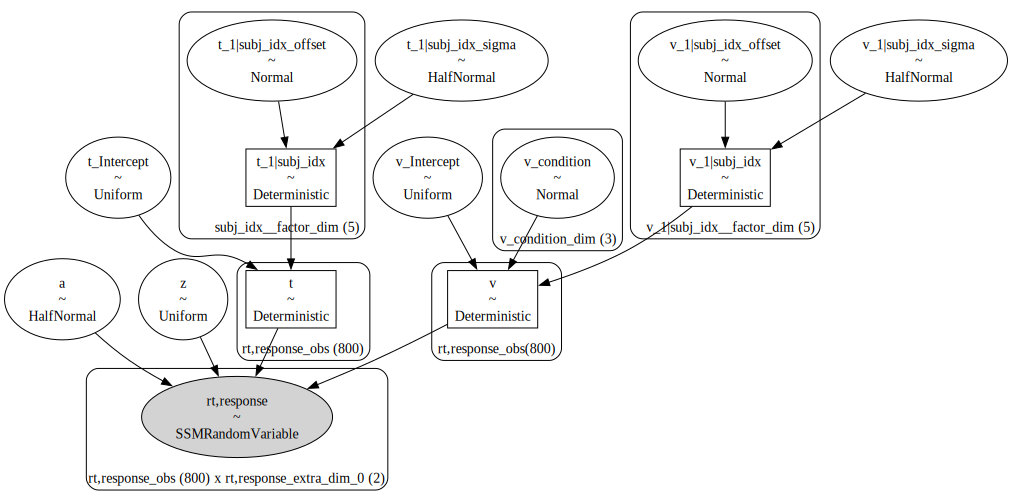

In [44]:
model_reg.graph()

In [45]:
infer_data_reg = model_reg.sample(
    sampler="nuts_numpyro", chains=4, cores=8, draws=3000, tune=1000
)

Compiling...
Compilation time = 0:00:10.914837
Sampling...
Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]








Running chain 0:   0%|          | 0/4000 [00:03<?, ?it/s]
























































Running chain 0:   5%|▌         | 200/4000 [00:06<00:48, 78.64it/s]


Running chain 0:  25%|██▌       | 1000/4000 [00:15<00:34, 86.16it/s]


Running chain 3: 100%|██████████| 4000/4000 [03:01<00:00, 22.07it/s]  
Sampling time = 0:03:01.650645
Transforming variables...
Transformation time = 0:00:01.240307


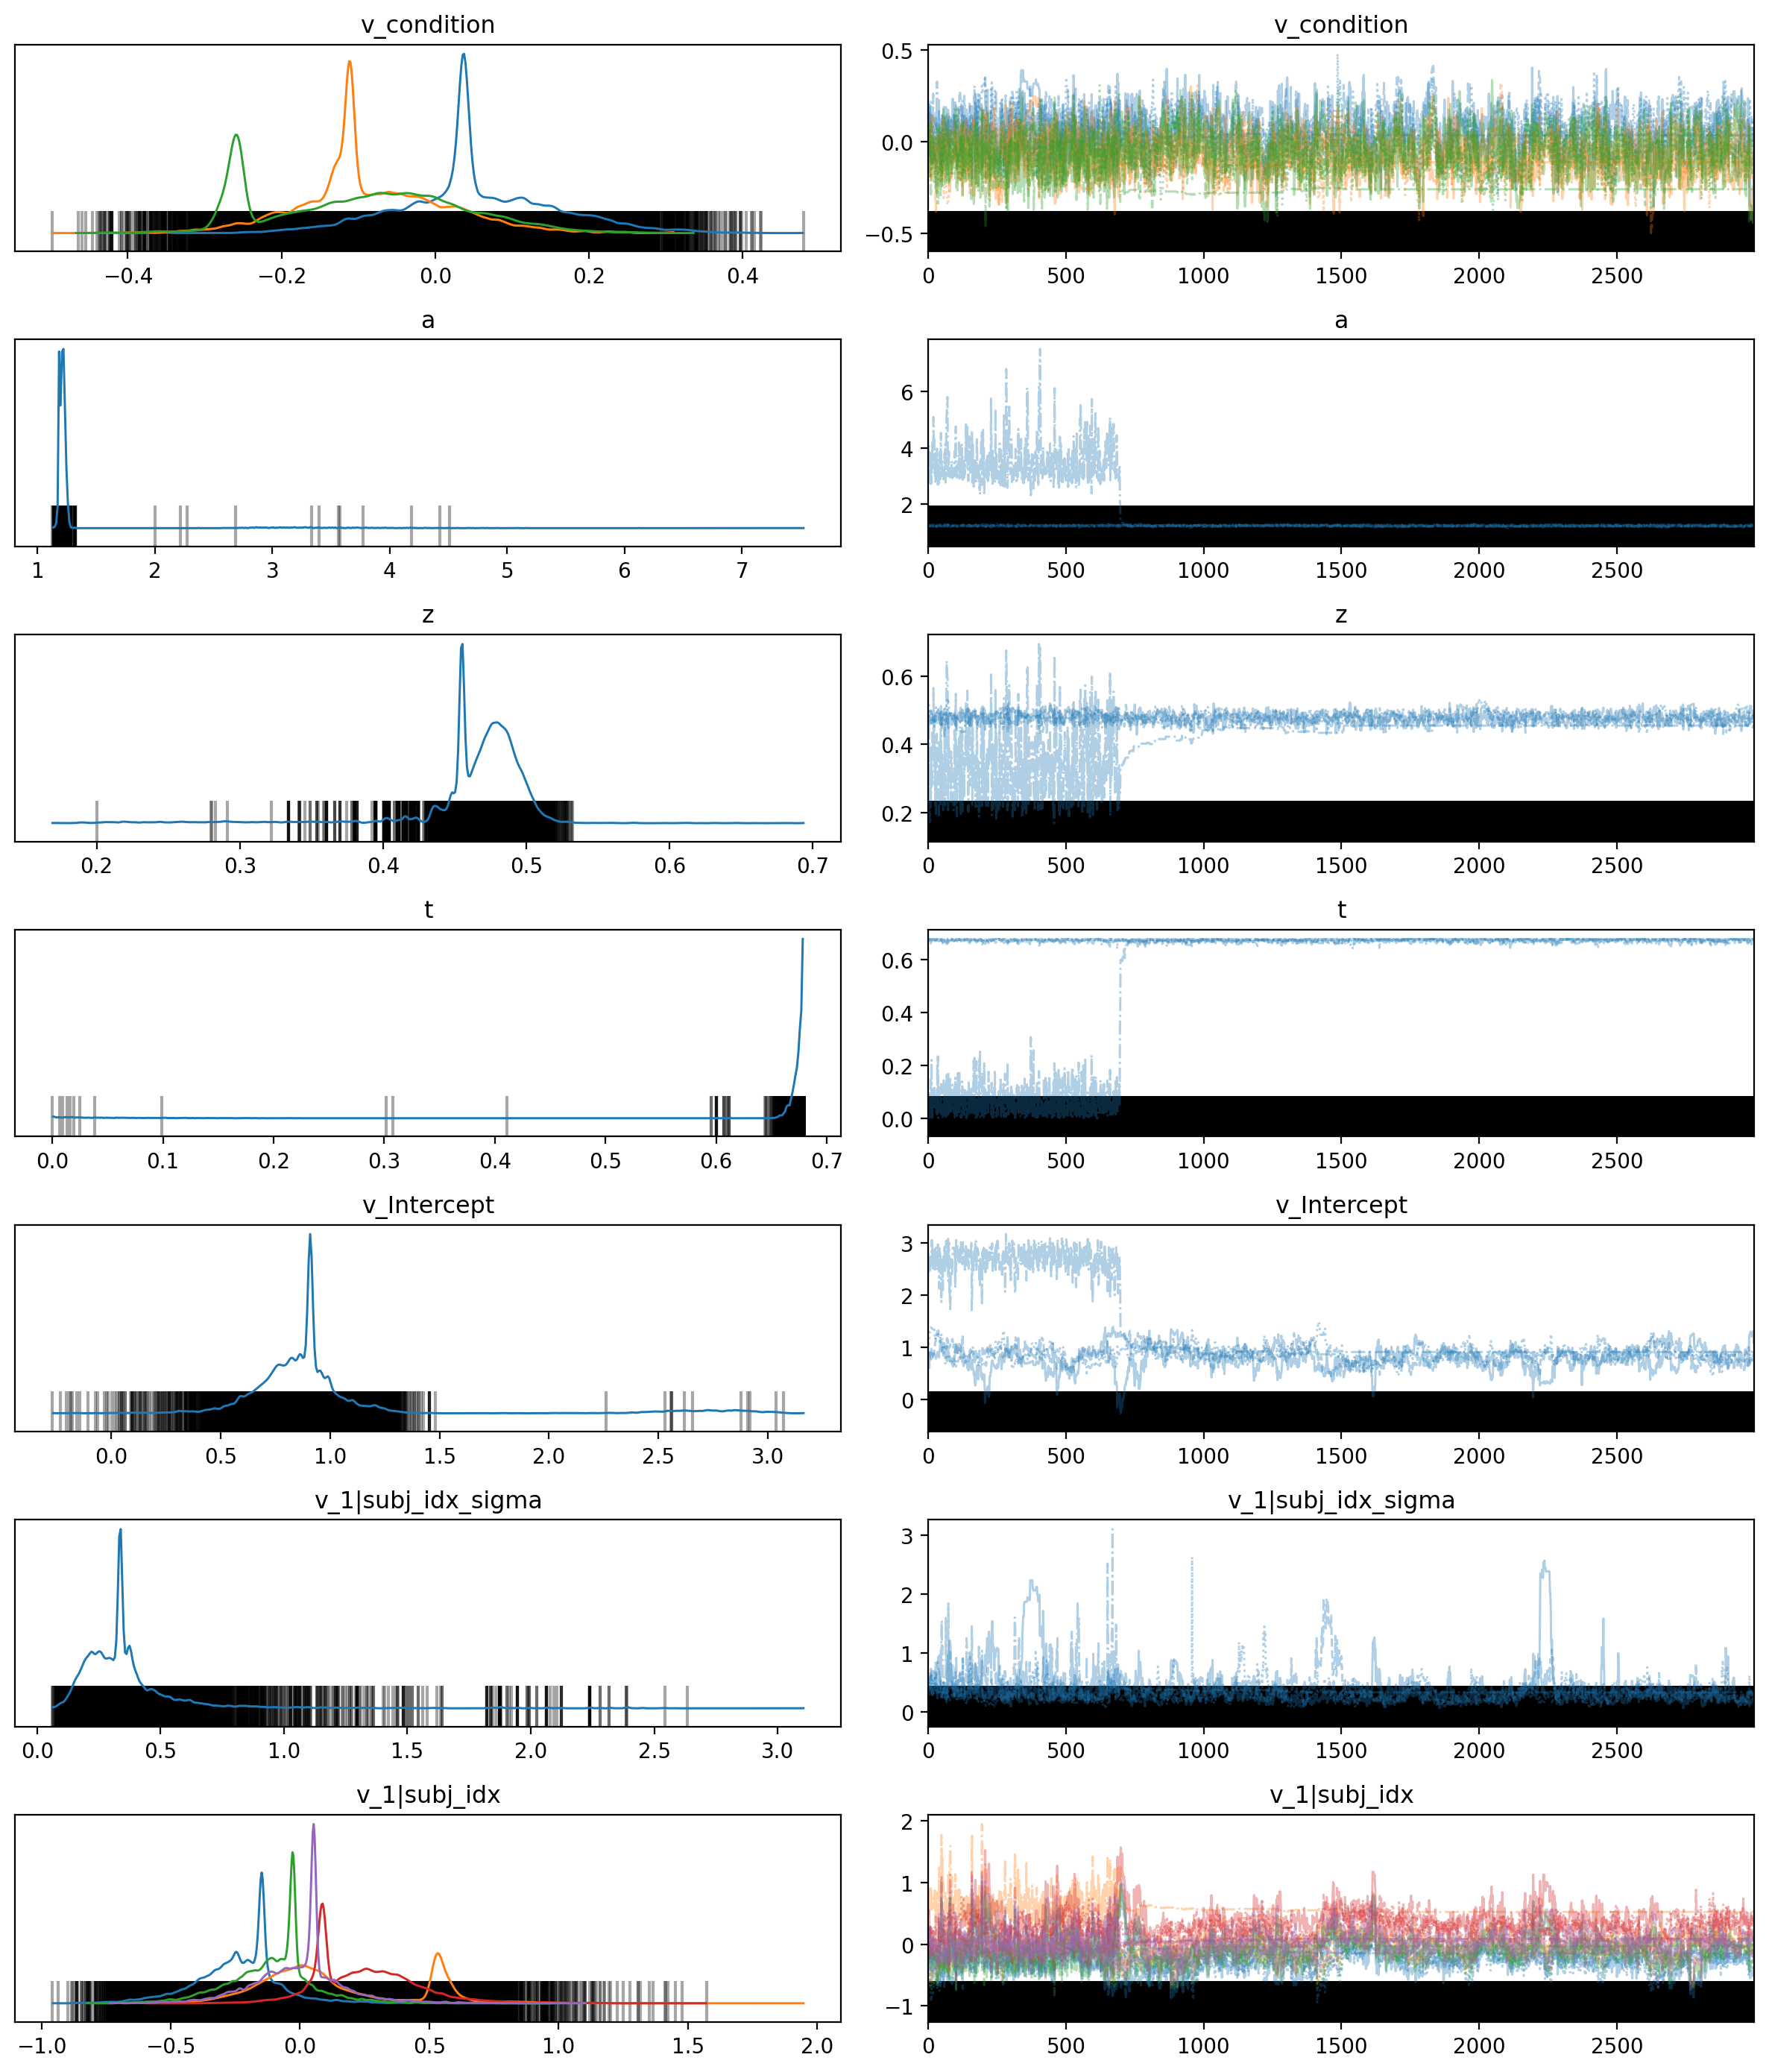

In [30]:
az.plot_trace(model_reg.traces, combined=True)
plt.tight_layout()

In [46]:
az.summary(infer_data_reg)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_condition[CO],-0.357,0.374,-0.996,-0.013,0.182,0.139,5.0,12.0,2.08
v_condition[SE],-0.518,0.374,-0.971,0.189,0.185,0.143,4.0,4.0,5.71
v_condition[SO],-0.416,0.237,-0.671,0.120,0.114,0.090,4.0,4.0,3.67
a,2.089,1.682,0.906,4.990,0.839,0.643,4.0,4.0,4.77
z,0.484,0.057,0.434,0.631,0.024,0.018,5.0,4.0,2.59
...,...,...,...,...,...,...,...,...,...
t[795],0.816,0.219,0.483,1.075,0.109,0.084,4.0,4.0,8.42
t[796],0.816,0.219,0.483,1.075,0.109,0.084,4.0,4.0,8.42
t[797],0.816,0.219,0.483,1.075,0.109,0.084,4.0,4.0,8.42
t[798],0.816,0.219,0.483,1.075,0.109,0.084,4.0,4.0,8.42


/Users/corrado/opt/anaconda3/envs/hssm_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/Users/corrado/opt/anaconda3/envs/hssm_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/Users/corrado/opt/anaconda3/envs/hssm_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/Users/

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

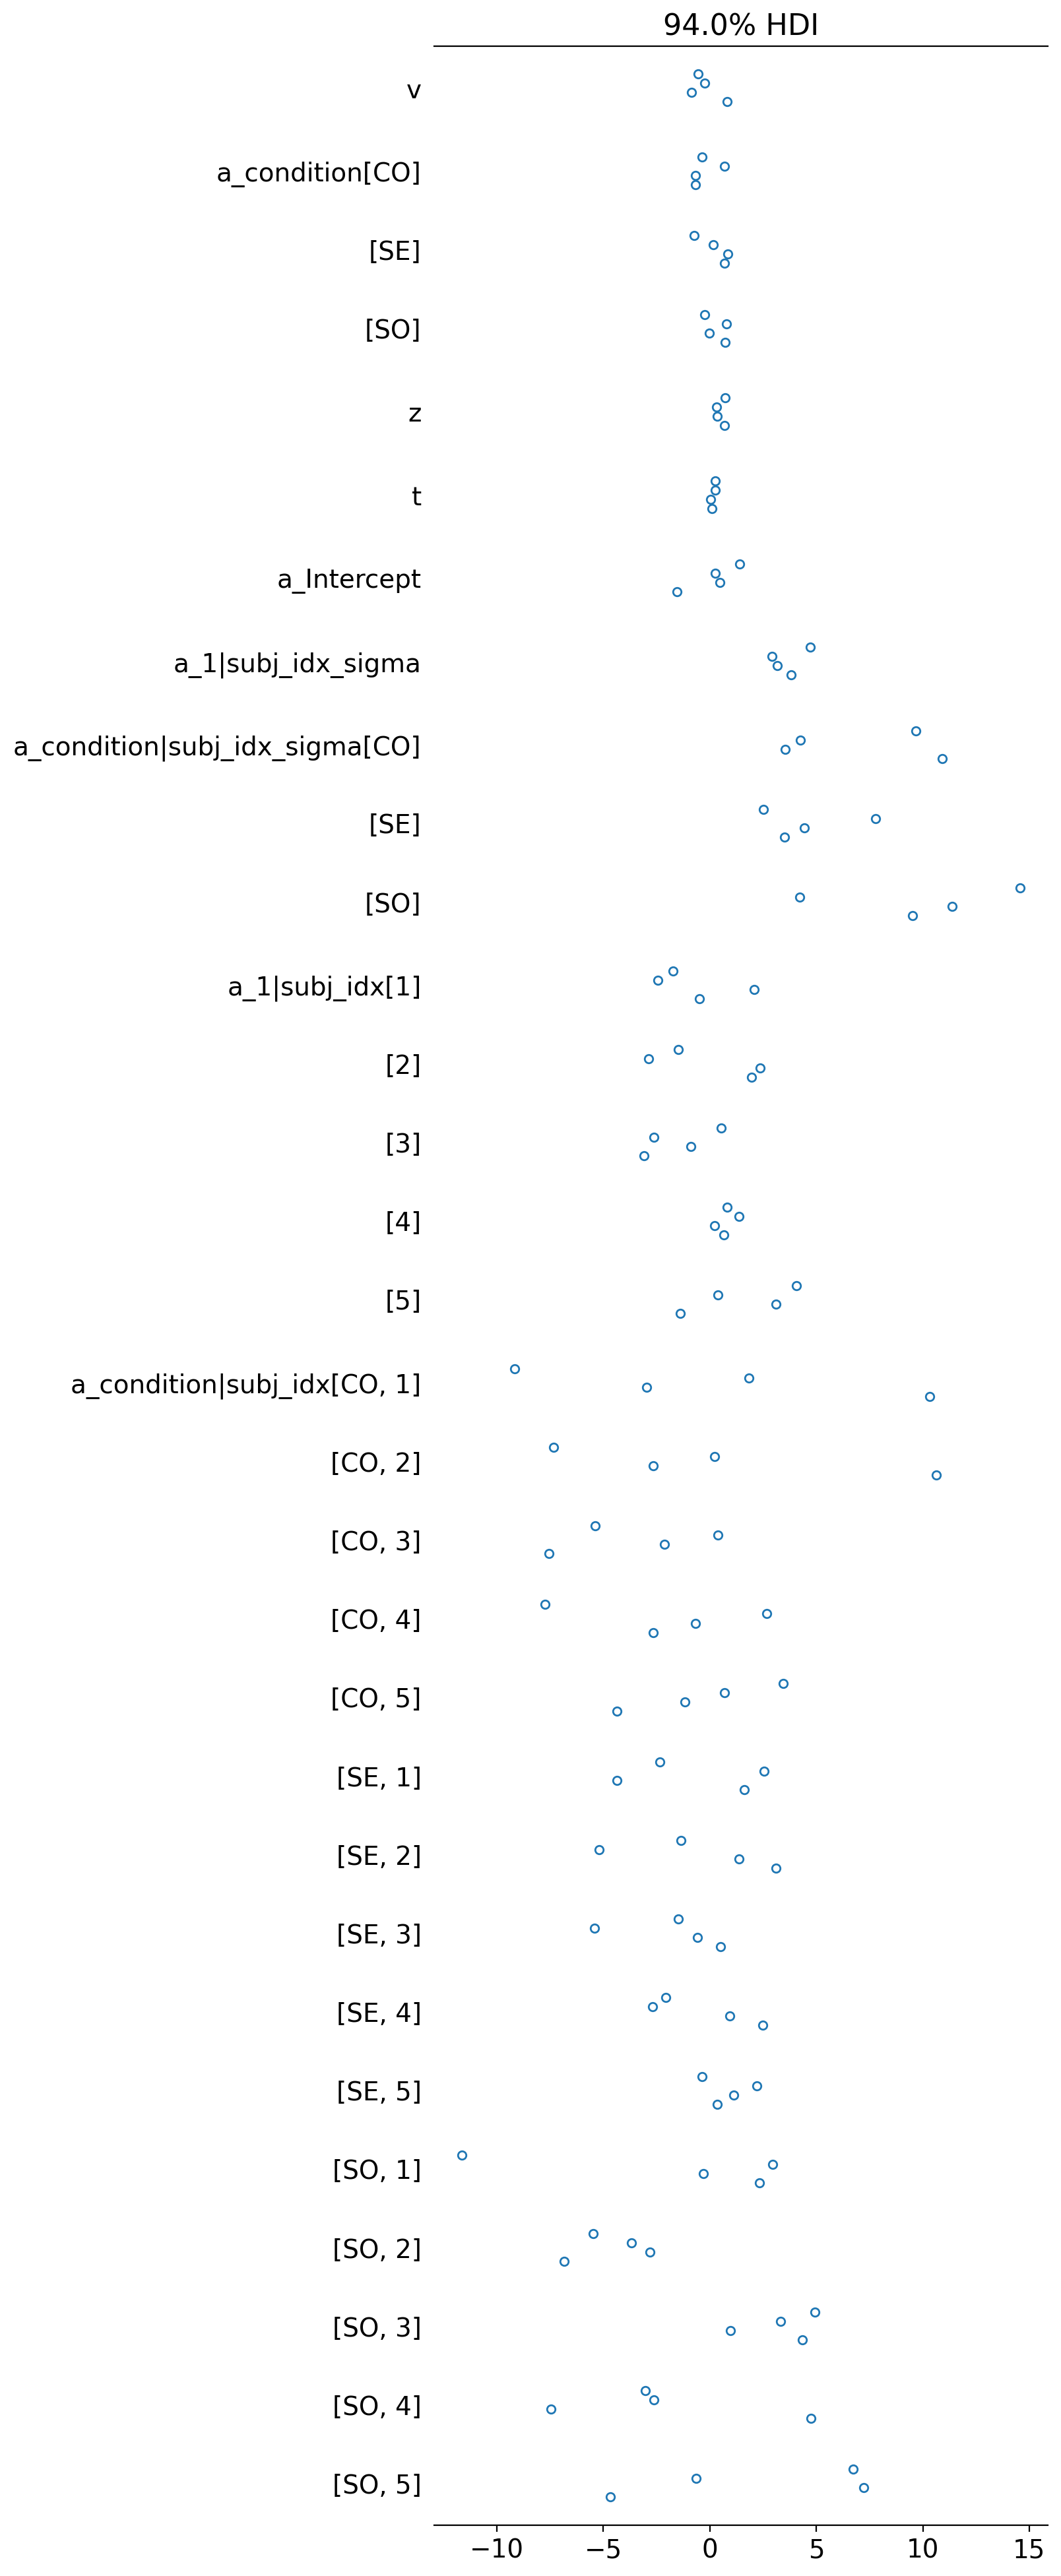

In [19]:
az.plot_forest(model_reg.traces)

In [47]:
df = data[["subj_idx", "condition", "rt", "response"]]
df.head()

,subj_idx,condition,rt,response
0,1,CE,2.709,1
1,1,CE,1.958,1
2,1,CE,3.000,-1
3,1,CE,1.873,1
4,1,CE,1.624,-1


In [36]:
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.2, 0.5]

obs_ddm_pymc = simulator([v_true, a_true, z_true, t_true], model="ddm", n_samples=1000)

dataset_pymc = pd.DataFrame(
    np.column_stack([obs_ddm_pymc["rts"][:, 0], obs_ddm_pymc["choices"][:, 0]]),
    columns=["rt", "response"],
)

TypeError: 'module' object is not callable

# This works best

In [70]:
model_reg_v_angle_hier = hssm.HSSM(
    data=df,
    model="angle",
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -2.0,
                    "upper": 2.0,
                    "initval": 0.0,
                },
            },
            "formula": "v ~ 1 + condition",
            "link": "identity",
        }
    ],
)

In [71]:
infer_data_reg_v = model_reg_v_angle_hier.sample(
    sampler="nuts_numpyro", chains=2, cores=8, draws=1500, tune=500
)

Compiling...
Compilation time = 0:00:00.955892
Sampling...
Running chain 1: 100%|██████████| 2000/2000 [01:53<00:00, 17.58it/s]
Sampling time = 0:01:54.034144
Transforming variables...
Transformation time = 0:00:00.779462


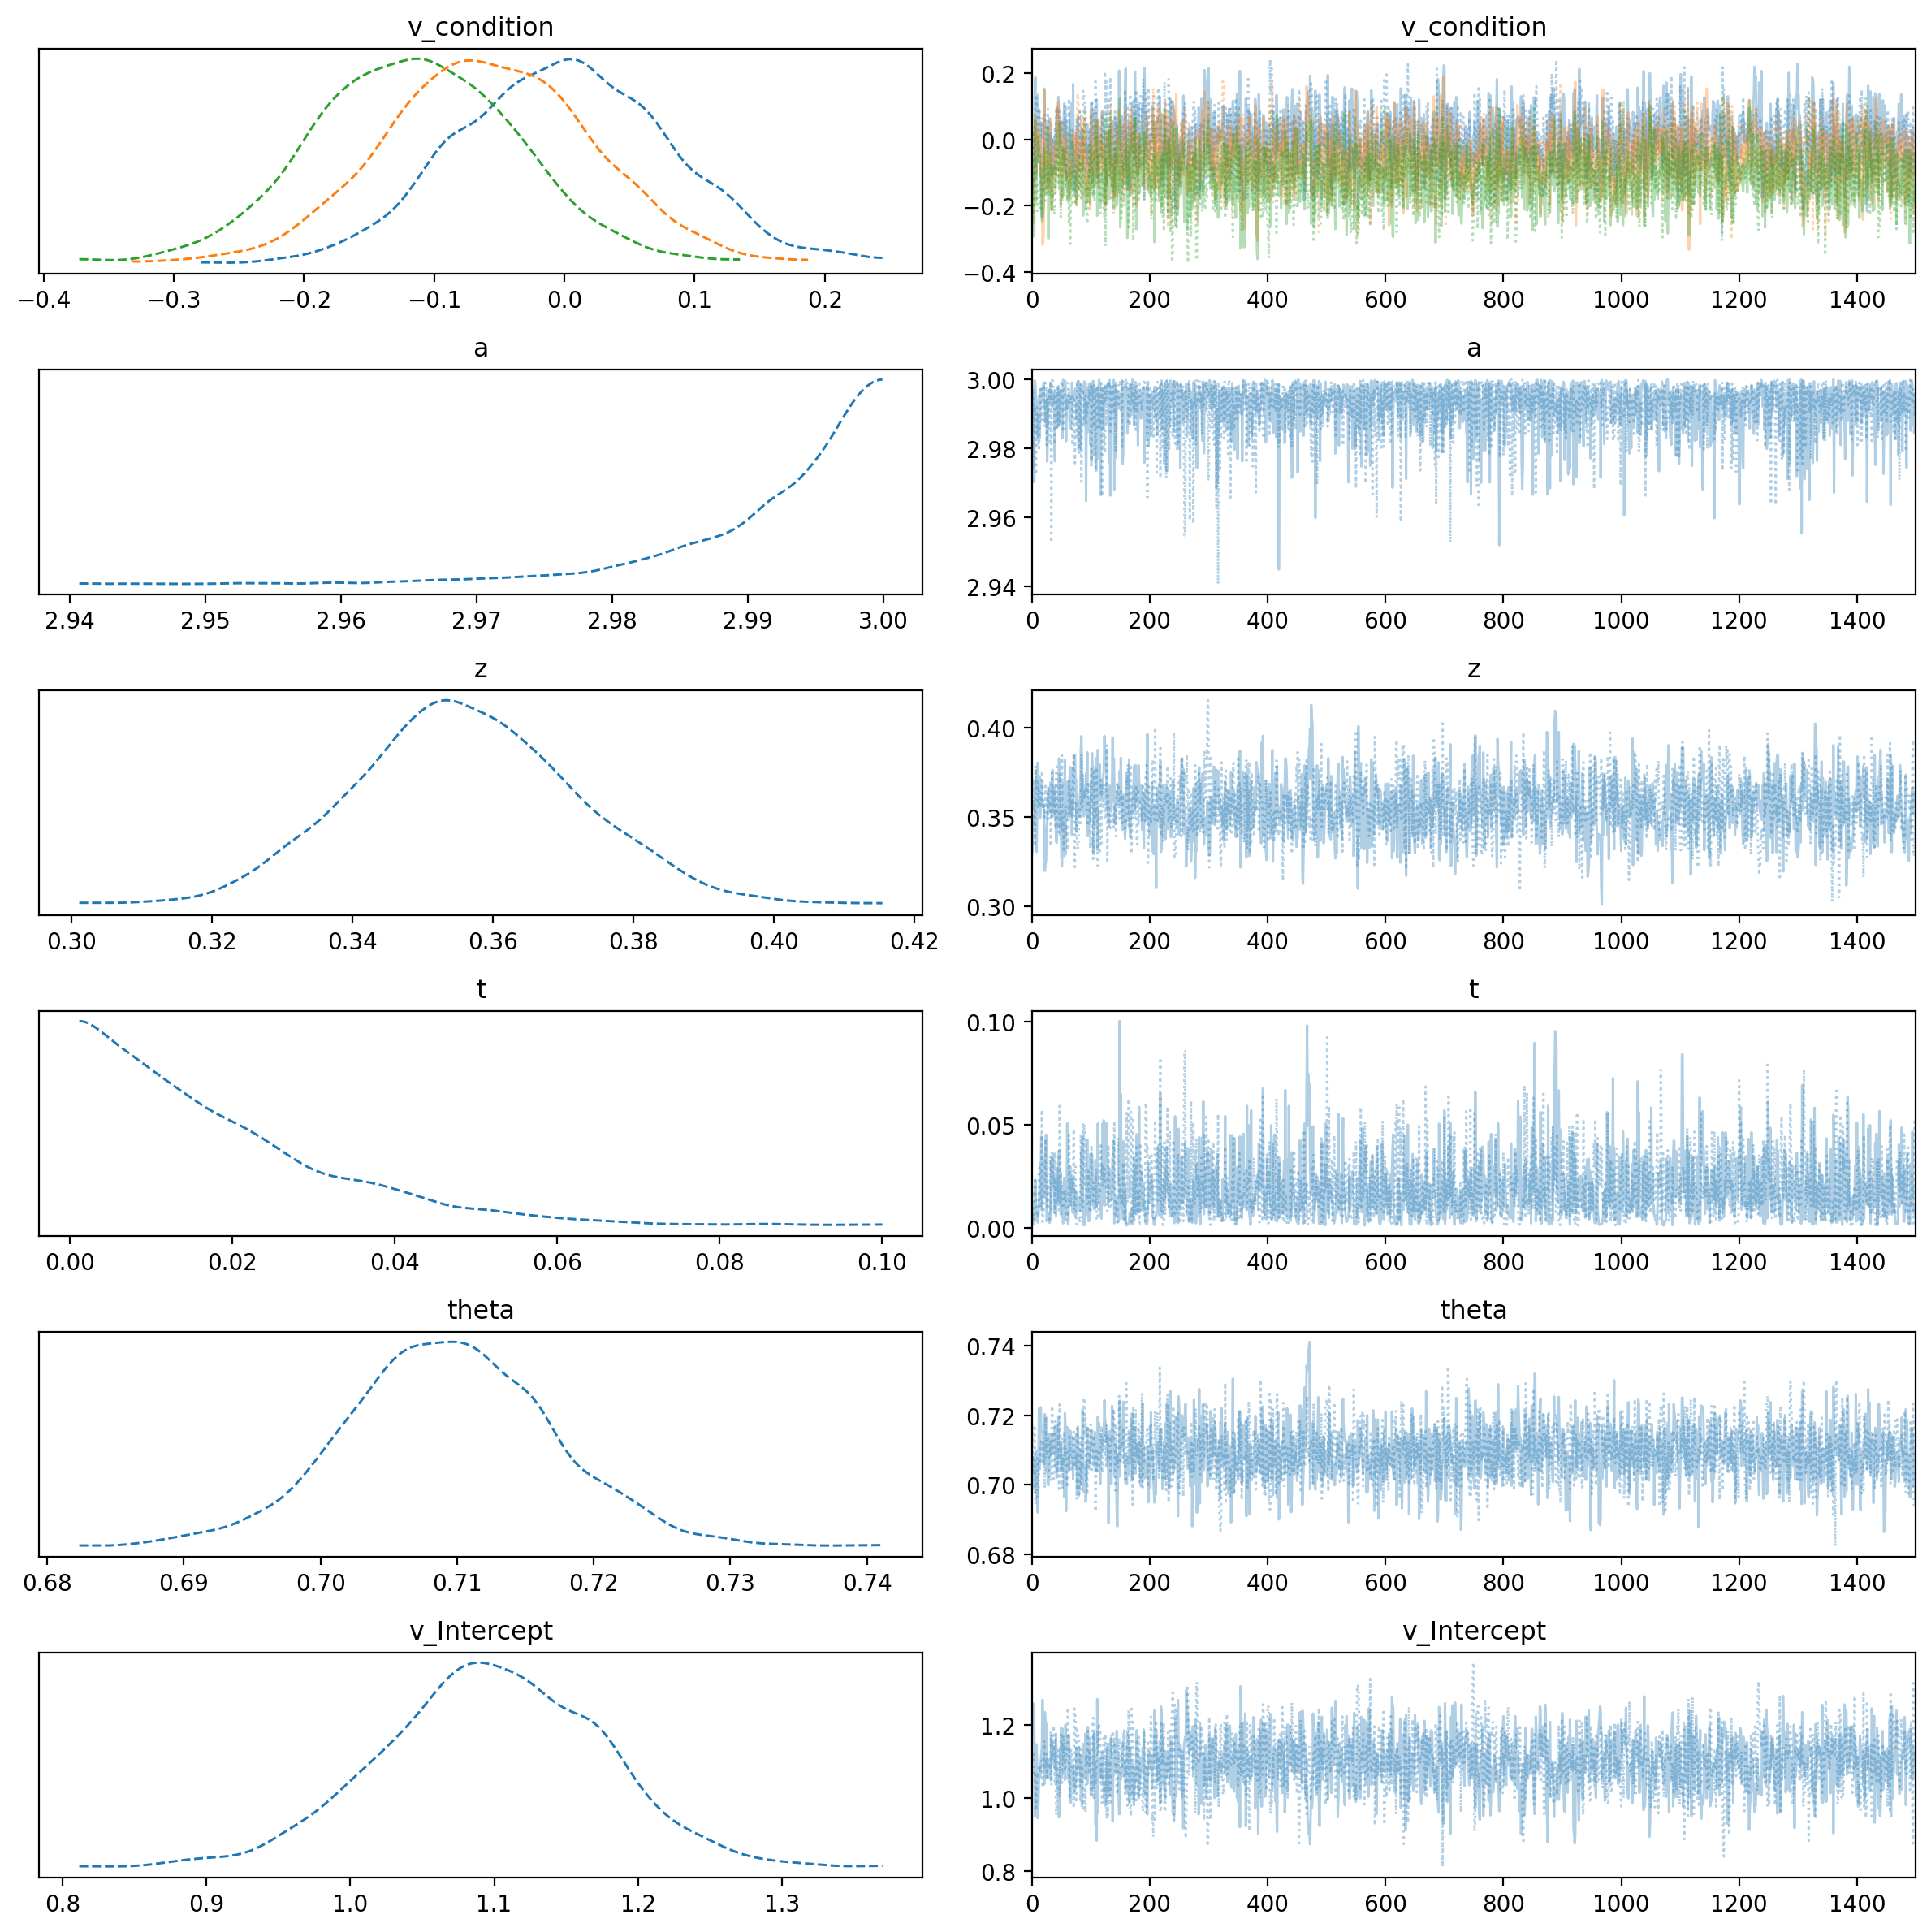

In [72]:
az.plot_trace(infer_data_reg_v, combined=True)
plt.tight_layout()

/Users/corrado/opt/anaconda3/envs/hssm_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/Users/corrado/opt/anaconda3/envs/hssm_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/Users/corrado/opt/anaconda3/envs/hssm_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/Users/

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

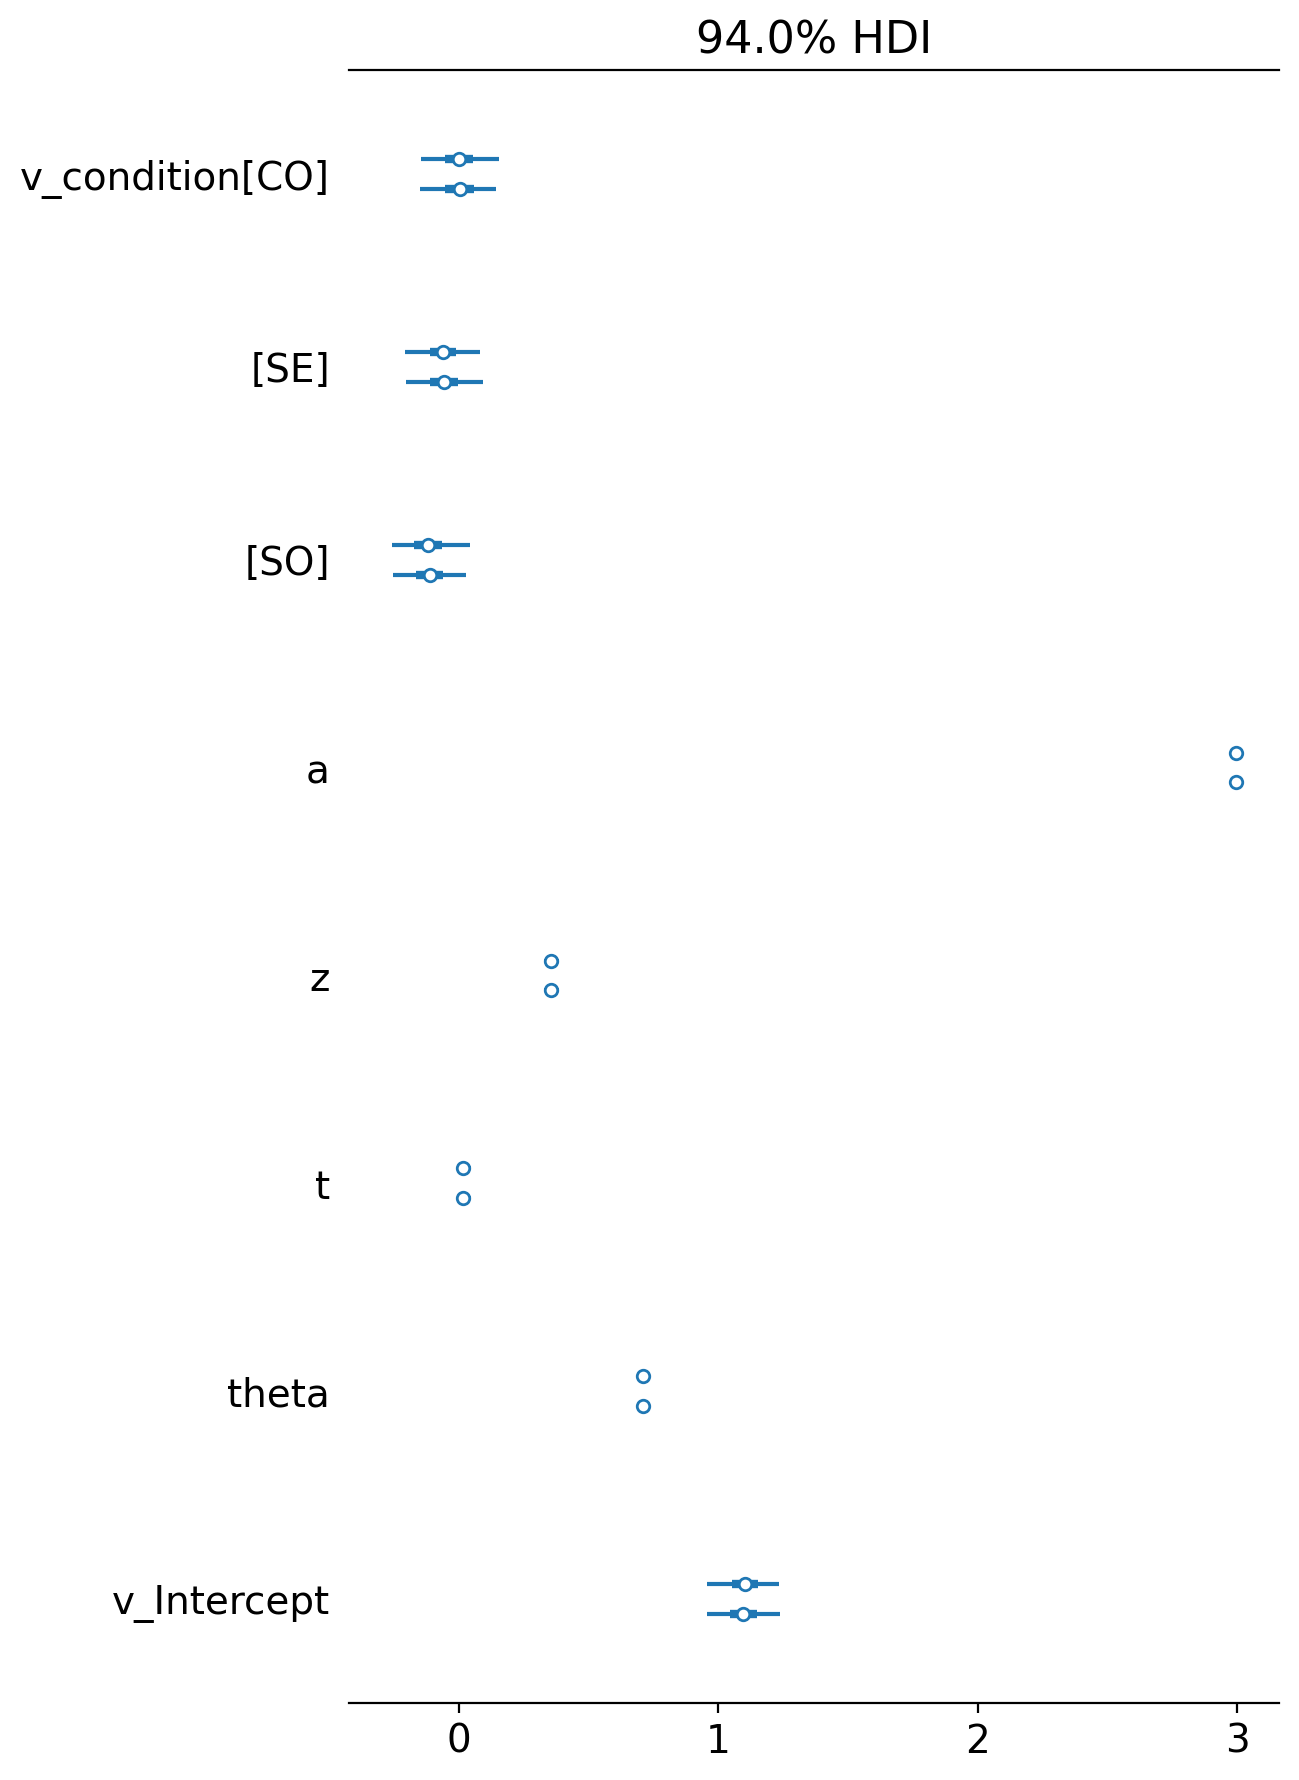

In [73]:
az.plot_forest(infer_data_reg_v)
